# Running noisy simulations

The aim of this notebook is to show how to do Monte Carlo simulations of noisy systems in __EMU-MPS__. The focus is on demonstrating the API, for information about the algorithm used, runtime and memory characteristics and potential pitfalls, please refer to the documentation.

We will run a sequence without driving or interactions, starting from the `11` state, with dephasing and spontaneous emission noise, and show that when enough Monte Carlo runs are performed, the probability to find the first qubit in the `1` state decays with the spontaneous emission rate, as expected. It is impossible to run the simulation for a single qubit, since __EMU-MPS__ does not support this edge case.

First we import the required packages

In [57]:
import pulser
import emu_mps
import numpy as np
import logging #used to turn of logging in emu_mps

Next we define the registers. Since we will turn off interactions, the qubit positions are arbitrarily chosen based on my number of fingers.

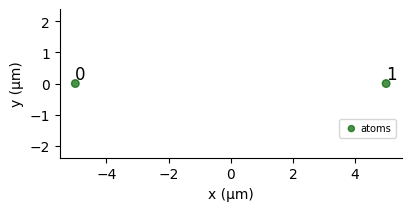

In [58]:
reg = pulser.Register.from_coordinates([[0,0],[10,0]])
reg.draw(blockade_radius=1e-10, draw_graph=True, draw_half_radius=True) #draw blockade radius as 0, since we will mask interactions in the MPSConfig

Next we define the `Sequence`. It consists of one constant pulse on the Rydberg channel with no amplitude and detuning. The duration of the pulse is taken as `t=1000` since it makes the graphs a nice length. It also has to be a multiple of whatever `dt` we choose below, which we keep at the default `dt=10`.

In [59]:
seq = pulser.Sequence(reg, pulser.devices.MockDevice)
t = 1000
pulse = pulser.Pulse.ConstantAmplitude(
        0., pulser.waveforms.ConstantWaveform(t, 0.), 0.0
    )
seq.declare_channel("ising_global", "rydberg_global")
seq.add(pulse, "ising_global")

We define the noise model to contain both a relaxation and a dephasing. For the system in question, dephasing has no actual influence on the dynamics since the system is always in an eigenstate of the dephasing jump operator. It's interesting to see that the correct relaxation rate still appears in the graphs though, which is why we are adding it. We're putting the rates to `1.` so that all the scaling of the graphs is in `t`

In [60]:
noise = pulser.NoiseModel(relaxation_rate=1, dephasing_rate=1.)

We'll measure the qubit density after each time step. Since we keep the default value of `dt=10` this means the measurements are at each multiple of `10ns`, as defined in `times` below.

In [61]:
times = np.arange(10, 1000, 10)
basis = ("r", "g")
magnetization = emu_mps.QubitDensity(evaluation_times=times, basis=basis, nqubits=2)

As described at the start of the notebook, we start from the `11` state.

In [62]:
#define initial state
initial_state = emu_mps.MPS.from_state_string(strings={"rr":1.},basis=basis, nqubits=2 )

Now we create the `MPSConfig` and `MPSBackend` for the above.

In [63]:
#define config and backend
config = emu_mps.MPSConfig(
    noise_model=noise,
    num_gpus_to_use=0, #small systems are faster on cpu
    interaction_cutoff=1e10, #this will put all interactions to 0, regardless of spacing
    initial_state=initial_state,
    observables=[magnetization],
    log_level = logging.WARN #don't print stuff for the many runs
)
backend = emu_mps.MPSBackend()

The way to handle results for many runs, is to store all the `Results` objects separately, and compute aggregated statistics from them afterwards.

In [72]:
results = []
nruns = 500 #0.125 seconds per run on my machine
for _ in range(nruns):
    results.append(backend.run(seq, config))

Utility function to extract the average magnetization of qubit 0 from all the results for each time. It takes an argument `n` for how many results to take. Naturally `n <= nruns`, and below we will vary it to show how the average magnetization converges to the ideal results with increasing `n`

In [73]:
def densities(results, n):
    return [np.mean([result.get_result(magnetization.name(), t)[0] for result in results[:n]]) for t in times]

Define the true mean of the magnetization towards which the sample statistics should converge as `nruns -> inf`

In [74]:
expected = [np.exp(-1*t/1000) for t in times]

Plot the magnetization. Here we see good agreement with the limit at `n=200` already, but if you're unlucky, even for `n=500` results can differ. 

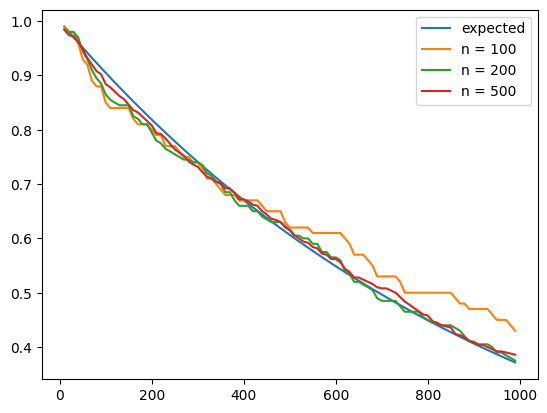

In [75]:
import matplotlib
import matplotlib.pyplot as pl
pl.plot(times, expected, label="expected")
for n in [100, 200, 500]:
    pl.plot(times, densities(results, n), label=f"n = {n}")
pl.legend(loc="upper right")